In [1]:
import numpy as np
import pandas as pd
np.random.seed(12345)
%matplotlib inline
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Getting the Data

In [2]:
iris_df = sns.load_dataset('iris')

In [3]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Group Summary

In [4]:
summary = iris_df.groupby('species').agg(['mean', 'std'])
summary

sepal_length           sepal_width           petal_length  \
                   mean       std        mean       std         mean   
species                                                                
setosa            5.006  0.352490       3.428  0.379064        1.462   
versicolor        5.936  0.516171       2.770  0.313798        4.260   
virginica         6.588  0.635880       2.974  0.322497        5.552   

                     petal_width            
                 std        mean       std  
species                                     
setosa      0.173664       0.246  0.105386  
versicolor  0.469911       1.326  0.197753  
virginica   0.551895       2.026  0.274650

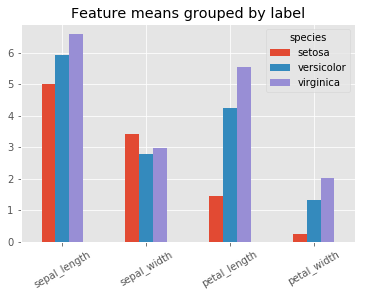

In [5]:
summary.xs('mean', axis=1, level=1).T.plot(kind='bar', title='Feature means grouped by label', rot=30)

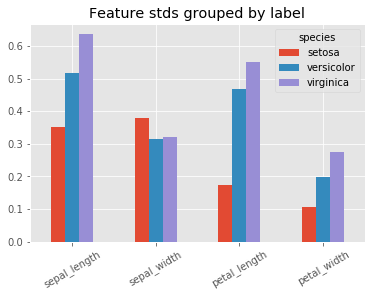

In [6]:
summary.xs('std', axis=1, level=1).T.plot(kind='bar', title='Feature stds grouped by label', rot=30)

# Train - Test Split

In [7]:
from sklearn.model_selection import train_test_split
y = pd.get_dummies(iris_df.species)
x_train, x_test, y_train, y_test = train_test_split(iris_df.drop('species', axis=1), y)

# Implement Cross-Entropy Loss

In [8]:
def softmax(output):
    """
    Return e^output / sum(e^output) in a numerically stable way.
    
    output is a 2D array, so the sum is taken over each row.
    """
    max_val = output.max(axis=1)
    y_hat = output.sub(output.max(axis=1), axis=0)
    y_hat = np.exp(y_hat)
    y_hat = y_hat.div(y_hat.sum(axis=1), axis=0)
    return y_hat
    
def cross_entropy_loss(output, y):
    # softmax
    y_hat = softmax(output)
    
    # cross-entropy loss is the average of - \sum_i y_i * y_i ln (\hat{y_i}) over all rows
    loss = - np.mean(np.dot(y, np.log(y_hat).T))
    return loss, y_hat

In [9]:
from numpy.linalg import norm

def classify(x_train, y_train, n_steps=50, learning_rate=1E-4, tol=1E-2):
    
    # initalize weight matrix shape [n_features, n_classes]
    w = np.random.rand(4, 3)
    losses = []
    
    for step in range(n_steps):
        # x_train: [n_obs, n_features]
        # out: [n_obs, n_classes]
        out = x_train.dot(w)
        
        # Loss is scalar
        # y_hat: [n_obs, n_classes]
        loss, y_hat = cross_entropy_loss(out, y_train)
        losses.append(loss)
        
        # print("Loss after step {} is: {:.2f}".format(step+1, loss))
        # Gradient descent: gradient of the softmax function is y = y_hat
        
        # loss_gradient: [n_obs, n_classes]
        loss_gradient = y_train.values - y_hat.values
        w_new = w + learning_rate * np.dot(x_train.values.T, loss_gradient)
        
        # print("norm(w - w_new): {}".format(norm(w - w_new)))
        
        if norm(w - w_new) < tol:
            print("Loss is: {:.2f}".format(loss))
            print("Classification GD has converged after {} iterations.".format(step+1))
            break
            
        w = w_new        
    
    return w, losses

In [10]:
w, losses = classify(x_train, y_train)

Loss is: 1.15
Classification GD has converged after 11 iterations.


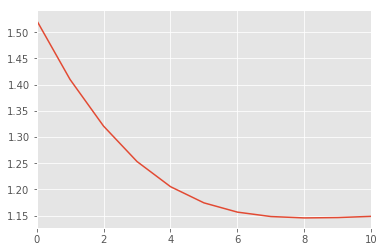

In [11]:
pd.Series(losses).plot()

# Prediction

In [12]:
def predict(w, x):
    out = x.dot(w)
    # y_hat is [n_obs, n_classes]
    # for each row, return the column index of the label with the highest probability
    y_hat = softmax(out)
    predictions = np.argmax(y_hat.values, axis=1)
    return predictions

In [13]:
pred_as_index = predict(w, x_test)

# map back to the string label
column_assignments = {idx: n for idx, n in enumerate(pd.get_dummies(y).columns)}
preds = [column_assignments[idx] for idx in pred_as_index]
preds = pd.Series(preds, name='predicted', index=y_test.index)

# actuals
actuals = iris_df.loc[y_test.index, 'species']

# Evaluation

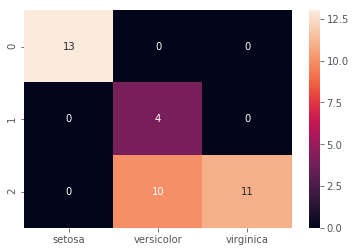

In [14]:
from sklearn.metrics import confusion_matrix

labels = iris_df.species.unique()
m = confusion_matrix(preds, actuals, labels=labels)
sns.heatmap(pd.DataFrame(data=m, columns=labels) , annot=True)

In [15]:
from sklearn.metrics import classification_report
print (classification_report(preds, actuals))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.29      1.00      0.44         4
   virginica       1.00      0.52      0.69        21

   micro avg       0.74      0.74      0.74        38
   macro avg       0.76      0.84      0.71        38
weighted avg       0.92      0.74      0.77        38

